In [1]:
# compile triplicates for negative disturbance (PSD)
# dilution, sample every 25 minutes

In [2]:
from FlowCytometryTools import *
import numpy as np
import pandas as pd
import math
import matplotlib
import matplotlib.pyplot as plt
import glob
import seaborn as sns
import pickle as pkl
from scipy.interpolate import interp1d
from scipy import stats

import os
import sys

path = "C:/Users/tayng/Documents/PythonScripts/cytometer"

if not path in sys.path:
    sys.path.insert(1, path)
    os.chdir(path)
    from AHN_FlowTools import *
del path

sns.set_style('white')
sns.set_style('ticks')
%matplotlib inline

os.chdir("C:/Users/tayng/Documents/PythonScripts/cytometer/CAGEKEY")

In [3]:
# update data directory
datadir = os.path.normpath("C:/Users/tayng/Documents/Data/cytometer/CAGEKEY/THN20181212_GEMZPM_PSDdisturbance_triplicates/")+os.sep
 
allfiles = {}
date1 = '20180806'
date2 = '20180820'
date3 = '20181211'

experiment = [date1, date2, date3]
date = '20180806'

for idx, exp in enumerate(experiment): 
    filepath = datadir + os.sep +'*.fcs'
    files = glob.glob(filepath)
    assert len(files)>0, "No filenames recovered - check file path: " + filepath
    allfiles[exp] = [files[idx]]

In [4]:
allexp = {}

for exp in experiment: # iterate through experiments (fcs files)
    for f in allfiles[exp]:
        allexp[exp] = FCMeasurement(ID = exp, datafile = f)
        
    allexp[exp].data = allexp[exp].data.loc[:, ['Time','SSC-H','FITC-H','mCherry-H','FSC-H']]

In [5]:
# settings
og_num = 1;        # number of outgrowth timepoints
samp_pd = 25;      # length of time b/w samples in min
summary_idx  = 1   # check summaryfile from labview
tot_reactors = pd.Series(range(1,9)) 

# read summary file
summaryfilepath = {}
summaryfile = {}
paths = {}
tot_timepoints = {}
paths[date1] = "THN20180806_summaryfile.csv"
paths[date2] = "THN20180820_summaryfile.csv"
paths[date3] = "THN20181211_summaryfile.csv"

for exp in experiment:
    summaryfilepath[exp] = os.path.normpath(datadir + paths[exp])
    summaryfile[exp] = pd.read_csv(summaryfilepath[exp], names=['timepoint','valve','start','end'])
    summaryfile[exp]['valve'] = summaryfile[exp]['valve'].astype(int)
    summaryfile[exp]['timepoint'] = summaryfile[exp]['timepoint'].astype(int)

tot_timepoints = pd.Series(range(0,49))

# create sample_order (valve # : order #)
valves = [5, 4, 7, 6, 11, 12, 2, 1]
order = [1, 2, 3, 4, 5, 6, 7, 8] # update
sample_order = {}

for i in range(len(valves)):
    sample_order[valves[i]] = order[i]


In [6]:
# legend 
labels = ['CL: no disturbance',
          'CL: 1.56',
          'CL: 3.13',
          'CL: 6.25',
          'OL: no disturbance',
          'OL: 1.56',
          'OL: 3.13',
          'OL: 6.25'];

In [7]:
# create binned_data
binned_data = {}
for exp in experiment:
    binned_data[exp] = pd.DataFrame(index=tot_reactors,columns=tot_timepoints)

for exp in experiment:
    for i, row in enumerate(summaryfile[exp].values): # iterate through summary file
        d = allexp[exp].data[allexp[exp].data.Time.between(summaryfile[exp].iloc[i,2],summaryfile[exp].iloc[i,3])]
        timepoint = summaryfile[exp].iloc[i,0] - summary_idx 
        if timepoint < 49:
            reactor_num = sample_order[summaryfile[exp].iloc[i,1]] # sample order gives the order of reactor (indexed at valve num)
            binned_data[exp].set_value(reactor_num, timepoint, d)

# Plot some things!!! 

In [8]:
# delete outgrowth timepoint(s)
t = (tot_timepoints*samp_pd)/60.0 
t_cut = t[0:49]
t_half = t[20:50]-10.0


In [9]:
def get_color():
    color=iter(sns.color_palette('hls',8))
    return(color)

def get_YFP_color():
    CL_color = iter(sns.color_palette(sns.color_palette("PuBu_r", 4)))
    return(CL_color)

# plot norm data

In [10]:
def get_norm_data(exp, reactor_num, timepoint, datatype):
    tp_data = binned_data[exp].loc[reactor_num, timepoint]
    tp_data = tp_data[tp_data[datatype] > 0] # filter out cells that have no FITC output
    tp_data = tp_data[tp_data['SSC-H'] > 1000]
    
    tot_events = tp_data.size
    time = np.median(tp_data.loc[:,'Time'])
    reading = tp_data.loc[:, datatype]
    
    raw_data = np.median(reading)
    ssc = tp_data.loc[:,'SSC-H']
    d = pd.Series(reading/ssc)
            
    d.dropna(how='any')    #to drop if all values in the row are nan
    yerr = np.std(d)
    d = np.median(d)
    return(d, raw_data, time, yerr)

In [11]:
# get normalized data data
rows = tot_reactors
cols = tot_timepoints
empty = pd.DataFrame(index = rows, columns = cols)

FITC = {}
mCherry = {}
for exp in experiment:
    FITC[exp] = pd.Panel({'time':empty, 'raw':empty, 'med':empty, 'sd':empty, 'ravg':empty})
    mCherry[exp] = pd.Panel({'time':empty, 'raw':empty, 'med':empty, 'sd':empty, 'ravg':empty})

    for reactor_num in tot_reactors:    
        for timepoint in tot_timepoints:
        
            data, raw_data, time, yerr = get_norm_data(exp, reactor_num, timepoint, 'FITC-H')
            FITC[exp].time.set_value(reactor_num, timepoint, time)
            FITC[exp].raw.set_value(reactor_num, timepoint, raw_data)
            FITC[exp].med.set_value(reactor_num, timepoint, data)
            FITC[exp].sd.set_value(reactor_num, timepoint, yerr)
            FITC[exp].ravg.set_value(reactor_num, timepoint, yerr)
        
            data, raw_data, time, yerr = get_norm_data(exp, reactor_num, timepoint, 'mCherry-H')
            mCherry[exp].time.set_value(reactor_num, timepoint, time)
            mCherry[exp].raw.set_value(reactor_num, timepoint, raw_data)
            mCherry[exp].med.set_value(reactor_num, timepoint, data)
            mCherry[exp].sd.set_value(reactor_num, timepoint, yerr)
            mCherry[exp].ravg.set_value(reactor_num, timepoint, yerr)


In [12]:
# get mean and sd data
FITC_all = {}
FITC_all = pd.Panel({'time':empty, 'med':empty, 'sd':empty, 'ravg':empty})

reactors_to_plot = {}
reactors_to_plot[date1] = [2, 6, 4, 8];
reactors_to_plot[date2] = [1, 4, 5, 8];
reactors_to_plot[date3] = [1, 2, 5, 6];

for i in range(4):
    for timepoint in tot_timepoints:
        
        d1 = FITC[date1].med.loc[reactors_to_plot[date1][i], timepoint]
        d2 = FITC[date2].med.loc[reactors_to_plot[date2][i], timepoint]
        d3 = FITC[date3].med.loc[reactors_to_plot[date3][i], timepoint]
        
        davg = np.mean([d1, d2, d3], dtype=np.float64)
        dyerr = np.std([d1, d2, d3], dtype=np.float64)

        FITC_all.med.set_value(i+1, timepoint, davg)
        FITC_all.sd.set_value(i+1, timepoint, dyerr)

In [13]:
def rolling_mean(readout, reactor_num, N):
    t_last = len(t)-1

    if readout == 'FITC-H':
        ravg = pd.rolling_mean(FITC_all.med.loc[reactor_num, :], N, center=True)
        ravg[0] = (FITC_all.med.loc[reactor_num, 0]+FITC_all.med.loc[reactor_num, 1])/2
        ravg[t_last] = (FITC_all.med.loc[reactor_num, t_last-1]+FITC_all.med.loc[reactor_num, t_last])/2
        
    return(ravg)

window = 3;
for reactor_num in range(1,9):
    FITC_all.ravg.loc[reactor_num, :] = rolling_mean('FITC-H',reactor_num, window)


C:\Users\tayng\Anaconda2\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=3,center=True).mean()
  """


# plot on log10 yscale

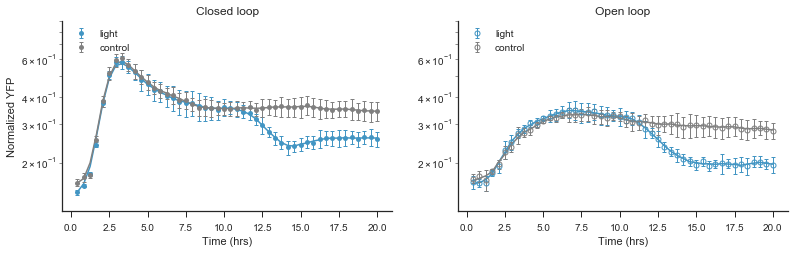

In [14]:
# plot on log 10 scale output over time
# rep 2
fig, ax = plt.subplots(1, 2, sharex = True, sharey = 'row', figsize = (13, 3.5))
YFP_color = get_YFP_color()
YFP_color_OL = get_YFP_color()

for k in range (1):
    c_YFP = next(YFP_color)
    c_YFP_OL = next(YFP_color_OL)

ms = 5
lw = 1.5
mew = 1
cs = 2
ct = 1

for reactor_num in tot_reactors: 
    if reactor_num == 2:
        ax[0].errorbar(t[1:49], FITC_all.med.loc[reactor_num, 1:49], FITC_all.sd.loc[reactor_num, 1:49], elinewidth=1, linestyle='none', marker='o', markersize=ms, capsize=cs, capthick=ct, color = 'grey')
        ax[0].plot(t[1:49], FITC_all.ravg.loc[reactor_num, 1:49], label='_nolegend_', linewidth = lw, color='grey')

    if reactor_num == 1:
        c_YFP = next(YFP_color)
        ax[0].errorbar(t[1:49], FITC_all.med.loc[reactor_num, 1:49], FITC_all.sd.loc[reactor_num, 1:49], elinewidth=1, linestyle='none', marker='o', markersize=ms, capsize=cs, capthick=ct, color = c_YFP)
        ax[0].plot(t[1:49], FITC_all.ravg.loc[reactor_num, 1:49], label='_nolegend_', linewidth = lw, color=c_YFP)

    if reactor_num == 4:
        ax[1].errorbar(t[1:49], FITC_all.med.loc[reactor_num, 1:49], FITC_all.sd.loc[reactor_num, 1:49], elinewidth=1, linestyle='none', marker='o', capsize=cs, capthick=ct, color = 'grey', markersize = 5, markeredgewidth=1, markerfacecolor = 'none', markeredgecolor='grey')
        ax[1].plot(t[1:49], FITC_all.ravg.loc[reactor_num, 1:49], label='_nolegend_', linewidth = lw, color='grey')

    if reactor_num == 3: 
        c_YFP_OL = next(YFP_color_OL)
        ax[1].errorbar(t[1:49], FITC_all.med.loc[reactor_num, 1:49], FITC_all.sd.loc[reactor_num, 1:49], elinewidth=1, linestyle='none', marker='o', capsize=cs, capthick=ct, color = c_YFP_OL, markersize = 5, markeredgewidth=1, markerfacecolor = 'none', markeredgecolor=c_YFP_OL)
        ax[1].plot(t[1:49], FITC_all.ravg.loc[reactor_num, 1:49], label='_nolegend_', linewidth = lw, color=c_YFP_OL)

ax[0].set_ylabel('Normalized YFP')
ax[0].set_title('Closed loop') 
ax[1].set_title('Open loop') 
ax[0].set_ylim([0.12, .9])

for i in range(2):
    ax[i].set_yscale('log')
    ax[i].legend(['light','control'],loc='upper left')

    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].set_xlabel('Time (hrs)')

dest = datadir + 'pyfig\\' + date + '_log10scaleoutput_compareDose'
plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)
plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
plt.show()
plt.close()

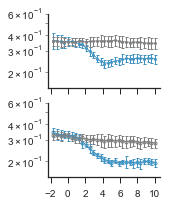

In [15]:
# plot on log 10 scale output over time

fig, ax = plt.subplots(2, 1, sharex = True, sharey = True, figsize = (2, 3.))
YFP_color = get_YFP_color()
YFP_color_OL = get_YFP_color()

for k in range (1):
    c_YFP = next(YFP_color)
    c_YFP_OL = next(YFP_color_OL)

ms = 3; lw = 1. ; mew = 1; cs = 1.5; ct = 1;

for reactor_num in tot_reactors: 
    if reactor_num == 2:
        ax[0].errorbar(t_half, FITC_all.med.loc[reactor_num, 20:50], FITC_all.sd.loc[reactor_num, 20:50], elinewidth=1, 
                       linestyle='none', marker='o', markersize=ms, capsize=cs, capthick=ct, color = 'grey')
        ax[0].plot(t_half, FITC_all.ravg.loc[reactor_num, 20:50], label='_nolegend_', linewidth = lw, color='grey')

    if reactor_num == 1:
        c_YFP = next(YFP_color)
        ax[0].errorbar(t_half, FITC_all.med.loc[reactor_num, 20:50], FITC_all.sd.loc[reactor_num, 20:50], elinewidth=1, 
                       linestyle='none', marker='o', markersize=ms, capsize=cs, capthick=ct, color = c_YFP)
        ax[0].plot(t_half, FITC_all.ravg.loc[reactor_num, 20:50], label='_nolegend_', linewidth = lw, color=c_YFP)

    if reactor_num == 4:
        ax[1].errorbar(t_half, FITC_all.med.loc[reactor_num, 20:50], FITC_all.sd.loc[reactor_num, 20:50], elinewidth=1, 
                       linestyle='none', marker='o', capsize=cs, capthick=ct, color = 'grey', markersize = ms, 
                       markeredgewidth=mew, markerfacecolor = 'none', markeredgecolor='grey')
        ax[1].plot(t_half, FITC_all.ravg.loc[reactor_num, 20:50], label='_nolegend_', linewidth = lw, color='grey')

    if reactor_num == 3: 
        c_YFP_OL = next(YFP_color_OL)
        ax[1].errorbar(t_half, FITC_all.med.loc[reactor_num, 20:50], FITC_all.sd.loc[reactor_num, 20:50], elinewidth=1, 
                       linestyle='none', marker='o', capsize=cs, capthick=ct, color = c_YFP_OL, markersize = ms, 
                       markeredgewidth=mew, markerfacecolor = 'none', markeredgecolor=c_YFP_OL)
        ax[1].plot(t_half, FITC_all.ravg.loc[reactor_num, 20:50], label='_nolegend_', linewidth = lw, color=c_YFP_OL)

#ax[0].set_ylabel('Normalized YFP')
#ax[0].set_title('Closed loop') 
#ax[1].set_title('Open loop') 
#ax[0].set_ylim([0.16, .65])

ax[1].set_xticks(np.arange(-2, 12, step=2))

for i in range(2):
    ax[i].set_ylim([.15, .6])
    ax[i].set_yscale('log')
    #ax[i].legend(['light','control'],loc='upper left')

    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    #ax[i].set_xlabel('Time (hrs)')

dest = datadir + 'pyfig\\' + date + '_log10scaleoutput_cropped'
plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)
plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
plt.show()
plt.close()

In [16]:
# get mean and sd data
ssFITC = {}
empty = pd.DataFrame(index = range(1,4), columns = range(1,4)) # columns are triplicates
ssFITC = pd.Panel({'avg':empty, 'precision':empty})

reactors_to_plot[date1] = [2, 6, 4, 8];
reactors_to_plot[date2] = [1, 4, 5, 8];
reactors_to_plot[date3] = [1, 2, 5, 6];

for i in range(4):
        
    d1 = np.mean(FITC[date1].med.loc[reactors_to_plot[date1][i], 43:49]);
    d2 = np.mean(FITC[date2].med.loc[reactors_to_plot[date2][i], 43:49]);
    d3 = np.mean(FITC[date3].med.loc[reactors_to_plot[date3][i], 43:49]);

    ssFITC.avg.set_value(i+1, 1, d1)
    ssFITC.avg.set_value(i+1, 2, d2)
    ssFITC.avg.set_value(i+1, 3, d3)


# rows
# 1 Cl
# 2 CL ctrl
# 3 OL
# 4 OL ctrl


In [18]:
# get precision measurements

for j in range(1,4): # iterate through triplicates
    for reactor_num in range(1,5): #iterate through reactors 
    
        # no disturbance value
        CL_NoDisturbance = ssFITC.avg.loc[2, j]; 
        OL_NoDisturbance = ssFITC.avg.loc[4, j];
    
        disturbance = ssFITC.avg.loc[reactor_num, j];

        if reactor_num == 1 or reactor_num == 2: 
            error = np.abs((disturbance-CL_NoDisturbance)/CL_NoDisturbance);
        
        elif reactor_num == 3 or reactor_num == 4:
            error = np.abs((disturbance-OL_NoDisturbance)/OL_NoDisturbance);
        
        precision = (error)**-1;
        ssFITC.precision.set_value(reactor_num, j, precision)


C:\Users\tayng\Anaconda2\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars


In [19]:
ssFITCprecision = {}
empty = pd.DataFrame(index = rows, columns = [0]) # columns are triplicates
ssFITCprecision = pd.Panel({'avg':empty, 'sd':empty})

for reactor_num in range(1,5):
        
    d1 = ssFITC.precision.loc[reactor_num, 1];
    d2 = ssFITC.precision.loc[reactor_num, 2];
    d3 = ssFITC.precision.loc[reactor_num, 3];
    
    davg = np.mean([d1, d2, d3], dtype=np.float64)
    dyerr = np.std([d1, d2, d3], dtype=np.float64)

    ssFITCprecision.avg.set_value(reactor_num, 0, davg)
    ssFITCprecision.sd.set_value(reactor_num, 0, dyerr)

C:\Users\tayng\Anaconda2\lib\site-packages\numpy\core\_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


0.0220570754565


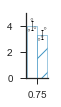

In [24]:
# plot precision
fig, ax = plt.subplots(figsize = (.4, 1.2))
ax = plt.subplot(111)

index = np.arange(1)
bar_width = 1.5;
cs = 1;
ct = 1;
space = np.array([0.2,0.5,0.8]);
lwidth = 0.5;
mwidth = 0.3;
size = 4;

CL_barlist = ax.bar(index, ssFITCprecision.avg.loc[1, 0], bar_width, label='Closed loop', 
                    yerr = ssFITCprecision.sd.loc[1, 0], linewidth = lwidth, 
                    error_kw=dict(lw=lwidth, capsize = cs, capthick = ct), color='y', fill=False)
OL_barlist = ax.bar(index + bar_width, ssFITCprecision.avg.loc[3, 0], bar_width, label='Open loop',
                    yerr = ssFITCprecision.sd.loc[3, 0], linewidth = lwidth,
                    error_kw=dict(lw=lwidth, capsize = cs, capthick = ct), color='y', fill=False)

# add the individual data points
idx=1;
for i in range(3): # closed loop reactors
    x = space[i]*bar_width-bar_width/2
    CL_scatter = ax.scatter(x, ssFITC.precision.loc[1, i+1], 
                            color='none', edgecolor = 'black', linewidth = mwidth, s=size)
for i in range(3): # open loop reactors
    x = space[i]*bar_width+bar_width/2
    OL_scatter = ax.scatter(x, ssFITC.precision.loc[3, i+1], 
                               color='none', edgecolor = 'black', linewidth = mwidth, s =size)

# two sided t-test
t1 = ssFITC.avg.loc[1, 1:3];
t2 = ssFITC.avg.loc[3, 1:3];
t, p = stats.ttest_ind(t1, t2)
print(p)

YFP_color = get_YFP_color()
YFP_color_OL = get_YFP_color()
c_YFP = next(YFP_color)
c_YFP_OL = next(YFP_color_OL)

for i in range(1):
    c_YFP = next(YFP_color)
    CL_barlist[i].set_color(c_YFP)
    OL_barlist[i].set_color(c_YFP)
    OL_barlist[i].set_hatch('/')

ax.set_ylim([0, 5.0])
ax.set_xticks(index + bar_width / 2)
#ax.legend()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

dest = datadir + 'pyfig\\' + date + '_precision'
plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)
plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)

plt.show()
plt.close()

In [ ]:
# plot on linear scale output over time

fig, ax = plt.subplots(2, 1, sharex = True, sharey = True, figsize = (2, 3.))
YFP_color = get_YFP_color()
YFP_color_OL = get_YFP_color()

for k in range (1):
    c_YFP = next(YFP_color)
    c_YFP_OL = next(YFP_color_OL)

ms = 5
lw = 1.5
mew = 1
cs = 2
ct = 1

for reactor_num in tot_reactors: 
    if reactor_num == 2:
        ax[0].errorbar(t_half[0:28], FITC_all.med.loc[reactor_num, 21:49], FITC_all.sd.loc[reactor_num, 21:49], elinewidth=1, linestyle='none', marker='o', markersize=ms, capsize=cs, capthick=ct, color = 'grey')
        ax[0].plot(t_half[0:28], FITC_all.ravg.loc[reactor_num, 21:49], label='_nolegend_', linewidth = lw, color='grey')

    if reactor_num == 1:
        c_YFP = next(YFP_color)
        ax[0].errorbar(t_half[0:28], FITC_all.med.loc[reactor_num, 21:49], FITC_all.sd.loc[reactor_num, 21:49], elinewidth=1, linestyle='none', marker='o', markersize=ms, capsize=cs, capthick=ct, color = c_YFP)
        ax[0].plot(t_half[0:28], FITC_all.ravg.loc[reactor_num, 21:49], label='_nolegend_', linewidth = lw, color=c_YFP)

    if reactor_num == 4:
        ax[1].errorbar(t_half[0:28], FITC_all.med.loc[reactor_num, 21:49], FITC_all.sd.loc[reactor_num, 21:49], elinewidth=1, linestyle='none', marker='o', capsize=cs, capthick=ct, color = 'grey', markersize = 5, markeredgewidth=1, markerfacecolor = 'none', markeredgecolor='grey')
        ax[1].plot(t_half[0:28], FITC_all.ravg.loc[reactor_num, 21:49], label='_nolegend_', linewidth = lw, color='grey')

    if reactor_num == 3: 
        c_YFP_OL = next(YFP_color_OL)
        ax[1].errorbar(t_half[0:28], FITC_all.med.loc[reactor_num, 21:49], FITC_all.sd.loc[reactor_num, 21:49], elinewidth=1, linestyle='none', marker='o', capsize=cs, capthick=ct, color = c_YFP_OL, markersize = 5, markeredgewidth=1, markerfacecolor = 'none', markeredgecolor=c_YFP_OL)
        ax[1].plot(t_half[0:28], FITC_all.ravg.loc[reactor_num, 21:49], label='_nolegend_', linewidth = lw, color=c_YFP_OL)

ax[0].set_ylabel('Normalized YFP')
ax[0].set_title('Closed loop') 
ax[1].set_title('Open loop') 
ax[0].set_ylim([0.16, .5])

for i in range(2):
    ax[i].legend(['light','control'],loc='upper left')

    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].set_xlabel('Time (hrs)')

dest = datadir + 'pyfig\\' + date + '_linear_cropped'
plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)
plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
plt.show()
plt.close()

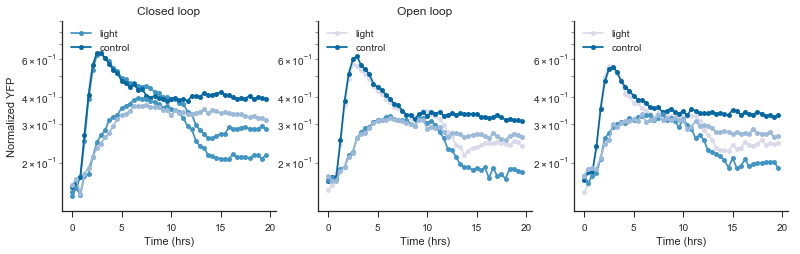

In [22]:
# individual experiments
# plot on log 10 scale output over time
# rep 2
fig, ax = plt.subplots(1, 3, sharex = True, sharey = 'row', figsize = (13, 3.5))

ms = 5; lw = 1.5; mew = 1; cs = 2; ct = 1;

reactors_to_plot[date1] = [2, 6, 4, 8];
reactors_to_plot[date2] = [1, 4, 5, 8];
reactors_to_plot[date3] = [1, 2, 5, 6];


for i, exp in enumerate(experiment):
    YFP_color = get_YFP_color()

    for j in range(4):
        reactor_num = reactors_to_plot[exp][j]
        ax[i].plot(t_cut[0:48], FITC[exp].med.loc[reactor_num, 1:48], marker='o', markersize=ms, color = c_YFP)
        c_YFP = next(YFP_color)

ax[0].set_ylabel('Normalized YFP')
ax[0].set_title('Closed loop') 
ax[1].set_title('Open loop') 
ax[0].set_ylim([0.12, .9])

for i in range(3):
    ax[i].set_yscale('log')
    ax[i].legend(['light','control'],loc='upper left')

    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].set_xlabel('Time (hrs)')

dest = datadir + 'pyfig\\' + date + '_log10scaleoutput_individual'
plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)
plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
plt.show()
plt.close()